In [3]:
from src.utils.io import load_results
from matplotlib import pyplot as plt
from src.utils.inference import get_dominant_frequency
import collections
import os
from collections import deque

import cv2
import numpy as np
import pandas as pd
import time
import zwoasi as asi

from src.camera.camera_setup import setup_camera
from src.camera.camera_stream import CameraStream
from src.camera.image_processing import get_clean_frame, \
    get_redness_frame, get_contours, get_contour_origin, get_largest_contour, \
    setup_kalman_filter
from src.fsm.fsm_calibration import get_amplitude_per_pixel
from src.fsm.fsm_setup import setup_fsm
from src.utils.general import wait
from src.utils.inference import show_images
from src.utils.io import save_results
from src.fsm.fsm import FSM

### Testing movement of FSM laser point

In [14]:
PORT: str = "/dev/cu.usbserial-249WO6MO"
BAUDRATE: int = 115200
TIMEOUT: int = 1
fsm_controller = setup_fsm(PORT, BAUDRATE, TIMEOUT)

origin_frames = [get_clean_frame(camera.capture(), master_dark) for _ in range(10)]
origin_image = np.median(origin_frames, axis = 0).astype(np.uint8)


o_contours = get_contours(origin_image)
o_largest_contour = get_largest_contour(o_contours)
origin_x, origin_y = get_contour_origin(o_largest_contour)

origin_image = cv2.cvtColor(origin_image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(
    image=origin_image,
    contours=o_contours,
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=8
)
cv2.circle(
    img=origin_image,
    center=(int(origin_x), int(origin_y)),
    radius=20,
    color=(255, 0, 0),
    thickness=-1
)

fsm_controller.send_command(f"control strategy feedforward")
amplitude = 0.25
fsm_controller.send_command(f"signal generate -a y -w dc -A {amplitude}")


calibrate_frames = [get_clean_frame(camera.capture(), master_dark) for _ in range(10)]
calibrate_image = np.median(calibrate_frames, axis = 0).astype(np.uint8)

fsm_controller.send_command(f"control strategy off")


c_contours = get_contours(calibrate_image)
c_largest_contour = get_largest_contour(c_contours)
calibrate_x, calibrate_y = get_contour_origin(c_largest_contour)

calibrate_image = cv2.cvtColor(calibrate_image, cv2.COLOR_GRAY2BGR)

cv2.drawContours(
    image=calibrate_image,
    contours=c_contours,
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=8
)
cv2.circle(
    img=calibrate_image,
    center=(int(calibrate_x), int(calibrate_y)),
    radius=20,
    color=(255, 0 ,0),
    thickness=-1
)

delta_x = abs(origin_x - calibrate_x)
delta_y = abs(origin_y - calibrate_y)

if delta_x == 0:
    delta_x += 1
amplitude_per_pixel_x: float = amplitude / delta_x
amplitude_per_pixel_y: float = amplitude / delta_y

show_images(origin_image, calibrate_image, )
print(f"ORi, X: {origin_x} Y: {origin_y}"
      f"CAL, X: {calibrate_x} Y: {calibrate_y}")
camera.stop_video_capture()
camera.close()

Error: [Errno 2] could not open port /dev/cu.usbserial-249WO6MO: [Errno 2] No such file or directory: '/dev/cu.usbserial-249WO6MO', Failed to connect to port /dev/cu.usbserial-249WO6MO
Not connected to FSM
Not connected to FSM
Not connected to FSM


ZWO_IOError: Camera closed

### Recreation of movement noise

Loaded square_.0A_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-07-21
Samples: 393
Time: 49.23527812957764


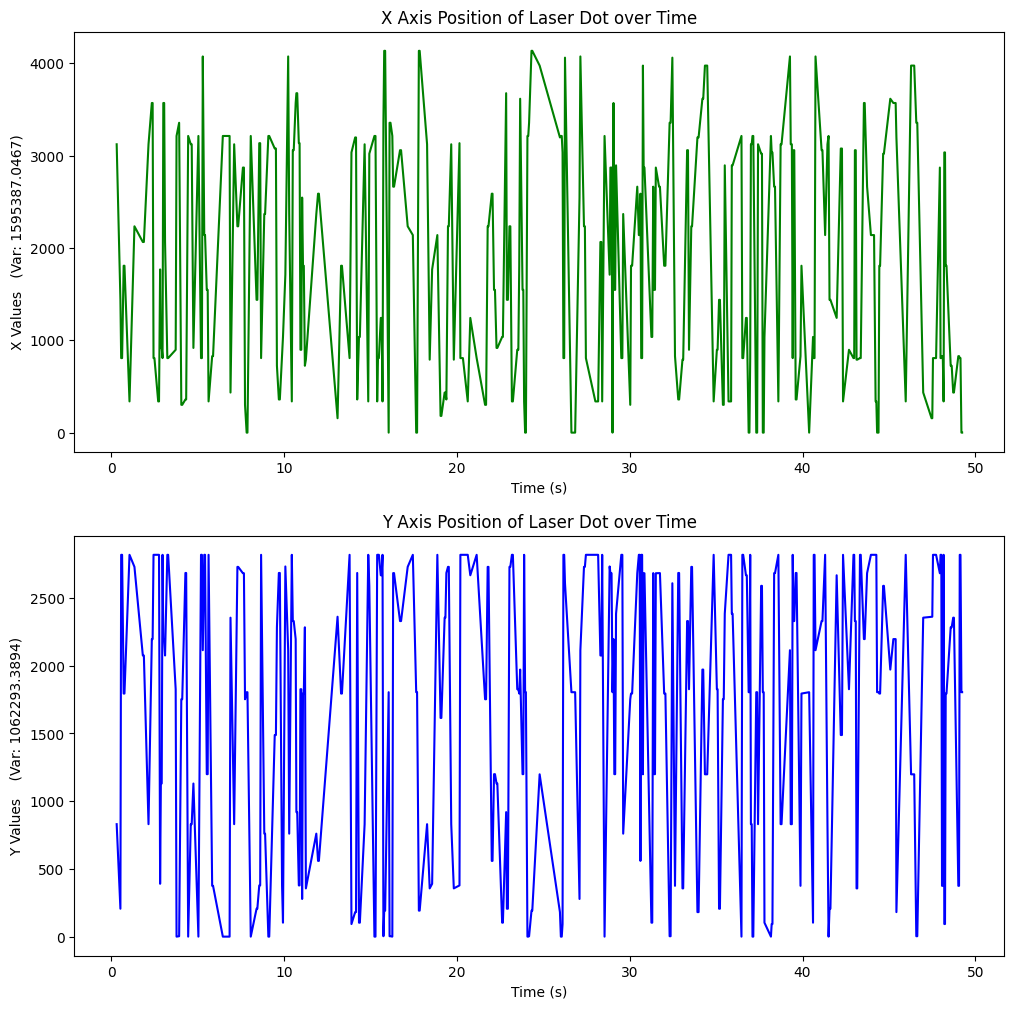

In [34]:
root_dir = os.path.dirname(os.getcwd())
results = load_results(root_dir, "square_.0A_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-21")
time_results = results["Time"]
x_results = results["X"]
y_results = results["Y"]
print(f"Samples: {len(results)}")
print(f"Time: {max(time_results)}")
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
axes[0].plot(time_results, x_results,color="g")
axes[0].set_title(f"X Axis Position of Laser Dot over Time")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel(f"X Values   (Var: {x_results.var():.4f})")


axes[1].plot( results["Time"], y_results, label=f"Variance {y_results.var()}",  color="b")
axes[1].set_title(f"Y Axis Position of Laser Dot over Time")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel(f"Y Values    (Var: {y_results.var():.4f})")

plt.show()


### Extracting predicted frequency of movement noise

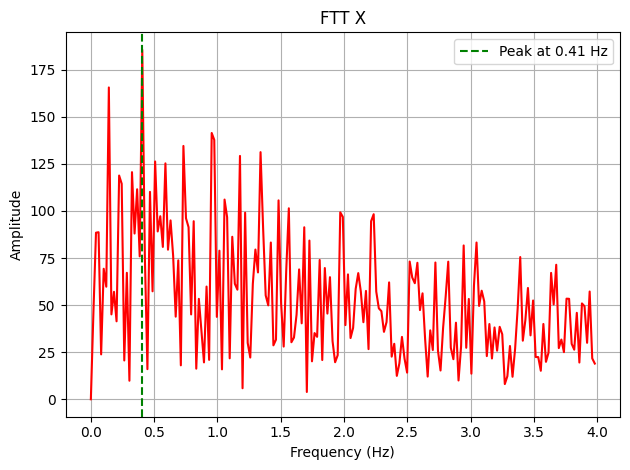

In [35]:
x_dominant_frequency, x_frequencies, x_power_spectrum = get_dominant_frequency(x_results, time_results)

plt.plot(x_frequencies, x_power_spectrum, color='r')
plt.title('FTT X')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.axvline(x_dominant_frequency, color='g', linestyle='--', label=f'Peak at {x_dominant_frequency:.2f} Hz')
plt.legend()

plt.tight_layout()
plt.show()

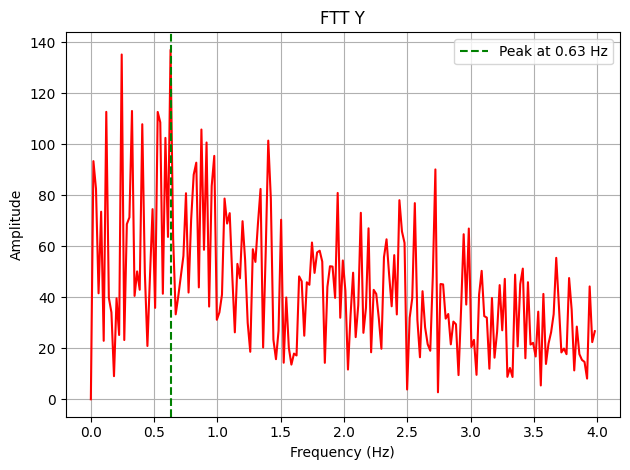

In [36]:
y_dominant_frequency, y_frequencies, y_power_spectrum = get_dominant_frequency(y_results, time_results)

plt.plot(y_frequencies, y_power_spectrum, color='r')
plt.title('FTT Y')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.axvline(y_dominant_frequency, color='g', linestyle='--', label=f'Peak at {y_dominant_frequency:.2f} Hz')
plt.legend()

plt.tight_layout()
plt.show()

### Error of actual frequency of movement noise and predicted frequency of noise

In [37]:
actual_frequency = 1.0
dominant_frequency = (x_dominant_frequency + y_dominant_frequency) / 2
error = (abs(dominant_frequency - actual_frequency) / actual_frequency) * 100
print(f"Error: {error:.2f}%")

Error: 48.21%


In [68]:
BINS = 2
GAIN = 120
EXPOSURE = 32  # µs
RESOLUTION = (8288, 5640)
START_POS = (0, 0)
FRAMES_DARK = 10
BUFFER_CAPACITY = 1
COLOUR: bool = False
# Contour mode for finding center of brightest point, if false cv2.minMaxLox will be used
CONTOUR_MODE: bool = True
CAMERA_ID: int = 0
SDK_LIB_NAME: str = 'libASICamera2.dylib'
root_dir = os.path.dirname(os.getcwd())
camera, master_dark = setup_camera(root_dir= root_dir,
                                      sdk_lib_name= SDK_LIB_NAME,
                                      camera_id= CAMERA_ID,
                                      bins=BINS,
                                      gain=GAIN,
                                      exposure=EXPOSURE,
                                      resolution= RESOLUTION,
                                      start_pos= START_POS,
                                      num_frames= FRAMES_DARK,
                                      colour=COLOUR)
camera_stream = CameraStream(camera).start()

Settings Reset to Default

ROI Set:
    Start X: 0
    Start Y: 0
    Resolution: 4144x2820
    Bins: 2

Using provided gain & exposure settings
Gain: 120, Exposure: 32µs

    AutoExpMaxExpMS
      - ControlType 11
      - DefaultValue 100
      - Description 'Auto exposure maximum exposure value(unit ms)'
      - IsAutoSupported False
      - IsWritable True
      - MaxValue 60000
      - MinValue 1
      - Name 'AutoExpMaxExpMS'
    AutoExpMaxGain
      - ControlType 10
      - DefaultValue 285
      - Description 'Auto exposure maximum gain value'
      - IsAutoSupported False
      - IsWritable True
      - MaxValue 570
      - MinValue 0
      - Name 'AutoExpMaxGain'
    AutoExpTargetBrightness
      - ControlType 12
      - DefaultValue 100
      - Description 'Auto exposure target brightness value'
      - IsAutoSupported False
      - IsWritable True
      - MaxValue 160
      - MinValue 50
      - Name 'AutoExpTargetBrightness'
    BandWidth
      - ControlType 6
      - Defau

### Intensity varation with power of laser

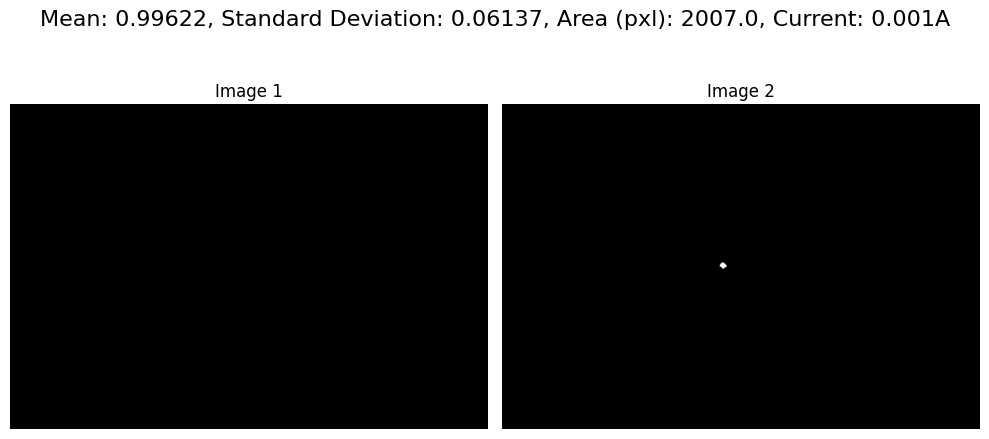

In [71]:
current = 0.001
current_unit: str = "A"
frames = 10
clean_frames = [get_clean_frame(camera.capture(), master_dark) for _ in range(frames)]
clean_image = np.median(clean_frames, axis = 0).astype(np.uint8)
contours = get_contours(clean_image)
if contours:
    lazer_blob = get_largest_contour(contours)
    mask = np.zeros(clean_image.shape, dtype=np.uint8)
    cv2.drawContours(mask,
                     [lazer_blob],
                     -1,
                     255,
                     thickness=cv2.FILLED)
    area = cv2.contourArea(lazer_blob) # Measured in pixels
    mean, std_dev = cv2.meanStdDev(clean_image, mask=mask)
    show_images(clean_image, mask, title= f"Mean: {mean[0,0]:.5f}, Standard Deviation: {std_dev[0,0]:.5f}, Area (pxl): {area}, Current: {current}{current_unit}")
else:
    area = 0.0
    mean = 0.0
    std_dev = 0.0
    show_images(clean_image, title= f"Couldn't find any contours, Mean: {mean:.5f}, Standard Deviation: {std_dev:.5f}, Area (pxl): {area}, Current: {current}{current_unit}")

### Intensity Results

In [65]:
camera.close()

In [66]:
error, mean, std_dev, current, area

(np.float64(48.207868486313856), 0.0, 0.0, 0.001, 0.0)

In [39]:
intensity_results = pd.DataFrame({
    "Frequency Error" : [
        48.2079, 71.3417, 74.1141, 3.017, 5.4405,
        4.2509, 0.7987, 4.1856, 2.6212, 1.2864,
        2.0884, 2.8698, 0.0767, 8.2045, 3.1407

    ],
    "Mean Intensity" : [
        0.0, 0.0, 0.0, 0.9962, 1.3467,
        2.6624, 9.1747, 19.4470, 34.7310, 52.8142,
        78.3584, 111.0976, 156.9581, 184.3910, 205.3289

    ],
    "Standard Deviation Intensity" : [
        0.0, 0.0, 0.0, 0.0613, 0.5073,
        0.7638, 3.4061, 7.5715, 12.5792, 20.0336,
        29.5215, 42.8003, 57.7703, 58.9460, 53.4733

    ],
    f"Current (A)" : [
        0.0, 0.001, 0.002, 0.003, 0.004,
        0.005, 0.01, 0.015, 0.02, 0.025,
        0.03, 0.035, 0.04, 0.045, 0.05

    ],
    f"Area (pxl)" : [
        0.0, 0.0, 0.0, 2021.0, 5292.0,
        4168.0, 6281.5, 6855.5, 6415.0, 6812.0,
        6810.5, 7013.0, 7178.0, 8979.5, 11202.0
    ]
})

In [59]:
save_results(root_dir, intensity_results, "intensity_results", True)

Saved intensity_results.csv in directory: /Users/Eric/PycharmProjects/satelite_tracking/results


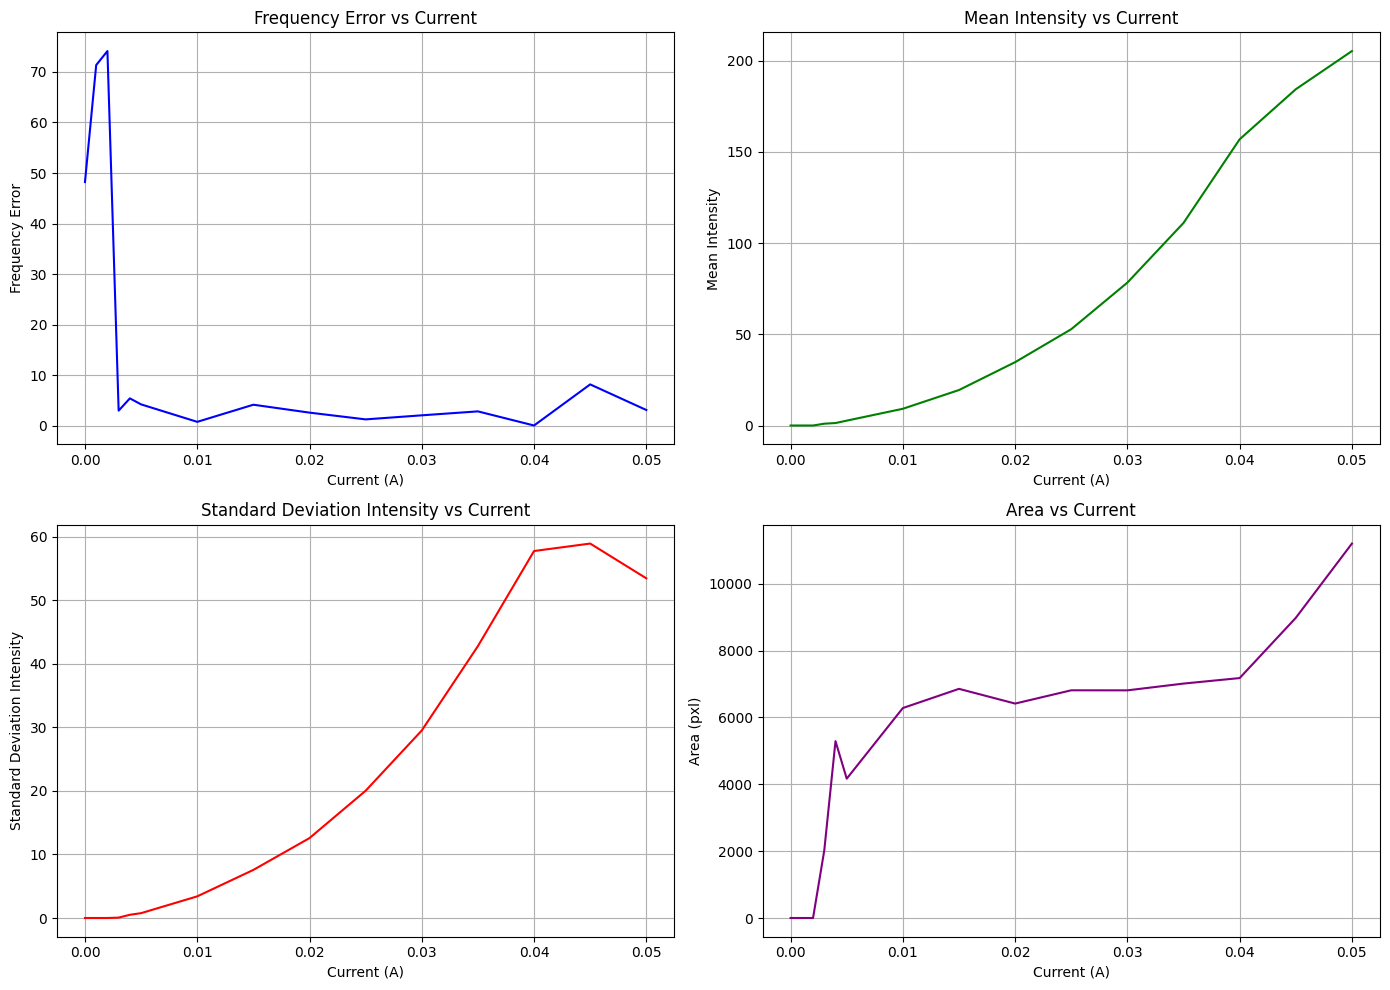

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(intensity_results["Current (A)"], intensity_results["Frequency Error"], color='blue')
axes[0, 0].set_title("Frequency Error vs Current")
axes[0, 0].set_ylabel("Frequency Error")
axes[0, 0].set_xlabel("Current (A)")
axes[0, 0].grid(True)

axes[0, 1].plot(intensity_results["Current (A)"], intensity_results["Mean Intensity"], color='green')
axes[0, 1].set_title("Mean Intensity vs Current")
axes[0, 1].set_ylabel("Mean Intensity")
axes[0, 1].set_xlabel("Current (A)")
axes[0, 1].grid(True)

axes[1, 0].plot(intensity_results["Current (A)"], intensity_results["Standard Deviation Intensity"], color='red')
axes[1, 0].set_title("Standard Deviation Intensity vs Current")
axes[1, 0].set_xlabel("Current (A)")
axes[1, 0].set_ylabel("Standard Deviation Intensity")
axes[1, 0].grid(True)

axes[1, 1].plot(intensity_results["Current (A)"], intensity_results["Area (pxl)"], color='purple')
axes[1, 1].set_title("Area vs Current")
axes[1, 1].set_ylabel("Area (pxl)")
axes[1, 1].set_xlabel("Current (A)")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


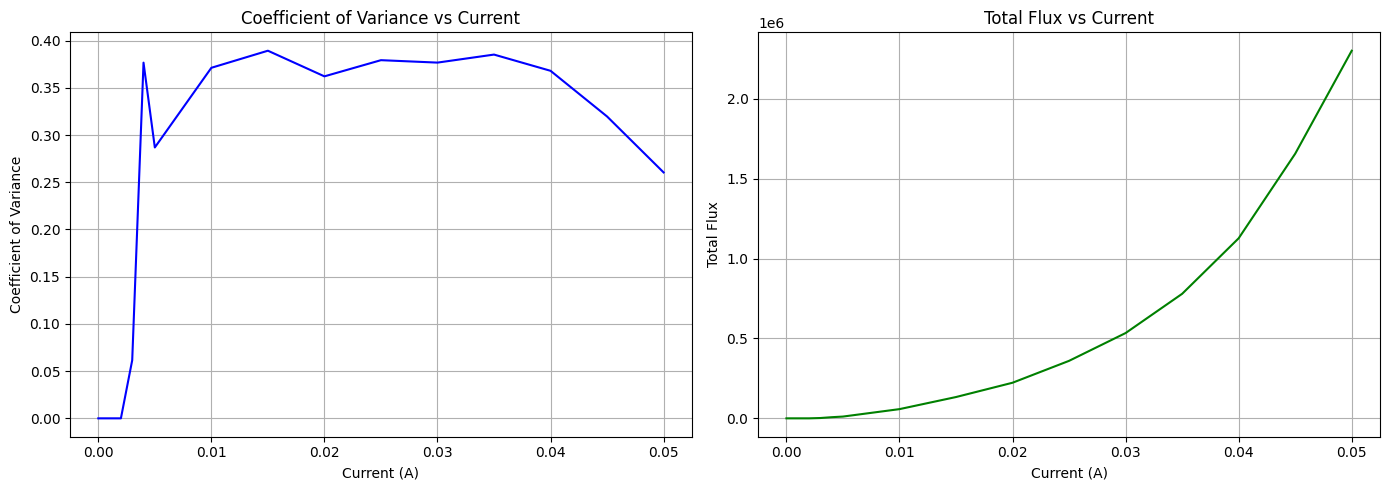

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

coefficient_of_variance = intensity_results["Standard Deviation Intensity"] / (intensity_results["Mean Intensity"] + 1e-9)
axes[0].plot(intensity_results["Current (A)"], coefficient_of_variance, color='blue')
axes[0].set_title("Coefficient of Variance vs Current")
axes[0].set_ylabel("Coefficient of Variance")
axes[0].set_xlabel("Current (A)")
axes[0].grid(True)

total_flux = intensity_results["Mean Intensity"] * intensity_results["Area (pxl)"]
axes[1].plot(intensity_results["Current (A)"], total_flux, color='green')
axes[1].set_title("Total Flux vs Current")
axes[1].set_ylabel("Total Flux")
axes[1].set_xlabel("Current (A)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [61]:
coefficient_of_variance

0      0.000000
1      0.000000
2      0.000000
3     16.251223
4      2.654642
5      3.485729
6      2.693609
7      2.568447
8      2.760986
9      2.636281
10     2.654282
11     2.595720
12     2.716934
13     3.128134
14     3.839840
dtype: float64